we're going to generate and visualize the distribution that has to be learn.

N(μ=10,σ=0.1) 

Our target distribution is a Gaussian distribution centered in  10  a with a standard deviation of  0.1 

We're going to use Tensorflow itself to sample datapoints from this distribution in order to build our training set.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
import pylab as pl

(0.0, 60.0)

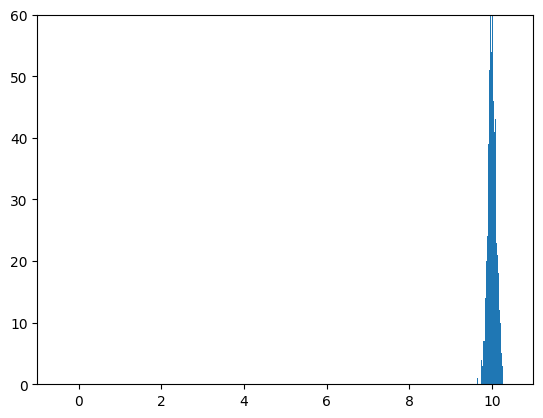

In [6]:
def sample_dataset():
    dataset_shape = (2000,1)
    return tf.random.normal(
        mean=10.0, shape=dataset_shape, stddev=0.1, dtype=tf.float32
    )

counts, bin, ignored = plt.hist(sample_dataset().numpy(), 100)
axes = plt.gca()
axes.set_xlim([-1,11])
axes.set_ylim([0,60])

## Generator and discriminator networks: Keras functional API

In [13]:
def build_generator(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu, name='fc1')(inputs)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu, name='fc2')(net)
    net = tf.keras.layers.Dense(1, name='G')(net)
    G = tf.keras.Model(inputs=inputs, outputs=net)
    return G

def build_discriminator(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    net = tf.keras.layers.Dense(32, activation=tf.nn.elu, name='fc1')(inputs)
    net = tf.keras.layers.Dense(1, name='D')(net)
    D = tf.keras.Model(inputs=inputs, outputs=net)
    return D

## Define input and instantiate networks

In [14]:
input_shape = (1,)

D = build_discriminator(input_shape)

latent_space_shape = (100,)

G = build_generator(latent_space_shape)

## The Loss function

In [15]:
def d_loss(real_output, generated_output):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(generated_output), generated_output)

def g_loss(generated_output):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(tf.ones_like(generated_output), generated_output)

## Training

In [18]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [22]:
@tf.function
def train_step():
    with tf.GradientTape() as d_tape:
        real_data = sample_dataset()
        fake_data = G(tf.random.normal([batch_size, latent_dim]))

        d_real = D(real_data)
        d_fake = D(fake_data)

        d_loss = d_loss_fn(d_real, d_fake)

    d_grads = d_tape.gradient(d_loss, D.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, D.trainable_variables))

    with tf.GradientTape() as g_tape:
        fake_data = G(tf.random.normal([batch_size, latent_dim]))
        d_fake = D(fake_data)
        g_loss = g_loss_fn(d_fake)

    g_grads = g_tape.gradient(g_loss, G.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, G.trainable_variables))

    return real_data, fake_data, g_loss, d_loss


NameError: in user code:

    File "C:\Users\aksha\AppData\Local\Temp\ipykernel_17524\3674384884.py", line 5, in train_step  *
        fake_data = G(tf.random.normal([batch_size, latent_dim]))

    NameError: name 'batch_size' is not defined


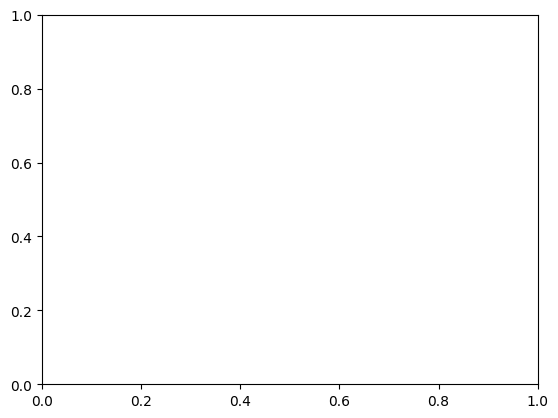

In [21]:

fig, ax = plt.subplots()
for step in range(40000):
    real_data, fake_data, g_loss_value, d_loss_value = train_step()
    if step % 200 == 0:
        print(
            "G loss: ",
            g_loss_value.numpy(),
            " D loss: ",
            d_loss_value.numpy(),
            " step: ",
            step,
        )

        # Sample 5000 values from the Generator and draw the histogram
        ax.hist(fake_data.numpy(), 100)
        ax.hist(real_data.numpy(), 100)
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

        # place a text box in upper left in axes coords
        textstr = f"step={step}"
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment="top",
            bbox=props,
        )

        axes = plt.gca()
        axes.set_xlim([-1, 11])
        axes.set_ylim([0, 60])
        display.display(pl.gcf())
        display.clear_output(wait=True)
        plt.savefig("./gif/{}.png".format(step))
        plt.gca().clear()

ValueError: in user code:

    File "C:\Users\aksha\AppData\Local\Temp\ipykernel_17524\198353821.py", line 32, in train_step  *
        d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    File "C:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\optimizers\adam.py", line 62, in __init__  **
        super().__init__(
    File "C:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\optimizer.py", line 21, in __init__
        super().__init__(*args, **kwargs)
    File "C:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 158, in __init__
        iterations = backend.Variable(
    File "C:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\common\variables.py", line 208, in __init__
        self._initialize(initializer)
    File "C:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 42, in _initialize
        self._value = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


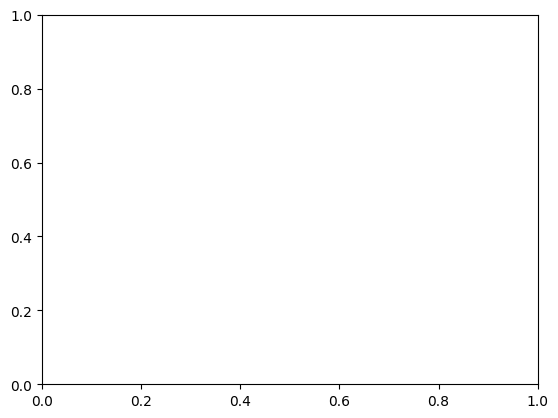

In [20]:
if not os.path.exists("./gif/"):
    os.makedirs("./gif/")

# Let's play the min-max game
def train():
    # Define the optimizers and the train operations
    g_optimizer = tf.keras.optimizers.Adam(1e-5)
    d_optimizer = tf.keras.optimizers.Adam(1e-5)

    @tf.function
    def train_step():
        with tf.GradientTape(persistent=True) as tape:
            real_data = sample_dataset()
            noise_vector = tf.random.normal(
                mean=0, stddev=1, shape=(real_data.shape[0], latent_space_shape[0])
            )
            # Sample from the Generator
            fake_data = G(noise_vector)
            # Compute the D loss
            d_fake_data = D(fake_data)
            d_real_data = D(real_data)
            d_loss_value = d_loss(generated_output=d_fake_data, real_output=d_real_data)
            # Compute the G loss
            g_loss_value = g_loss(generated_output=d_fake_data)
        # Now that we have computed the losses, we can compute the gradients 
        # (using the tape) and optimize the networks
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        del tape

        # Apply gradients to variables
        d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

        return real_data, fake_data, g_loss_value, d_loss_value

    # 40000 training steps with logging every 200 steps
    fig, ax = plt.subplots()
    for step in range(40000):
        real_data, fake_data, g_loss_value, d_loss_value = train_step()
        if step % 200 == 0:
            print(
                "G loss: ",
                g_loss_value.numpy(),
                " D loss: ",
                d_loss_value.numpy(),
                " step: ",
                step,
            )

            # Sample 5000 values from the Generator and draw the histogram
            ax.hist(fake_data.numpy(), 100)
            ax.hist(real_data.numpy(), 100)
            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

            # place a text box in upper left in axes coords
            textstr = f"step={step}"
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=14,
                verticalalignment="top",
                bbox=props,
            )

            axes = plt.gca()
            axes.set_xlim([-1, 11])
            axes.set_ylim([0, 60])
            display.display(pl.gcf())
            display.clear_output(wait=True)
            plt.savefig("./gif/{}.png".format(step))
            plt.gca().clear()


train()

### 